In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. 加载数据，并查看数据

In [3]:
data_train = pd.read_csv('E:\\tianchi\\titanic\\train.csv')
data_test = pd.read_csv('E:\\tianchi\\titanic\\test.csv')

### 1.1 数据初探

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### 可以看出，共有891个样本，其中，Age字段有部分缺失，Cabin字段缺失严重，Embarked字段有两个缺失。

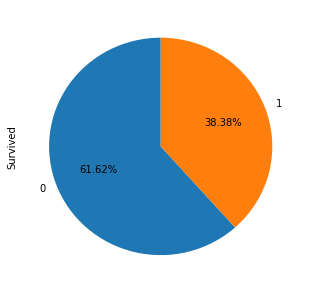

In [196]:
#给出存活比例
data_train['Survived'].value_counts().plot.pie(autopct = '%1.2f%%',startangle = 90,figsize = (5,5))
## data_train.groupby('Survived')['Survived'].count().plot(kind = 'pie',startangle = 90,autopct = '%1.2f%%')

#### 由上图可知，有大约38%的人获救

## 2. 数据简单处理

#### Age这一特征对预测影响较大，应谨慎处理，打算用随机森林来预测年龄，进而进行填充。
#### Cabin 这一特征也缺失较多，可用一个新的标记来表示缺失的数据特征
#### Embarked  这个特征在训练集里缺失2个，测试集里没有缺失，可用众数代替

In [5]:
#填充Cabin
data_train['Cabin'] = data_train['Cabin'].fillna('U0')

#用众数来填充Embarked，众数为S
data_train['Embarked'] = data_train['Embarked'].fillna('S')

In [6]:
#对于Sex,处理成数字
data_train['Sex_num'] = 0
data_train.loc[data_train['Sex'] == 'male','Sex_num'] = 1
data_train.loc[data_train['Sex'] == 'female','Sex_num'] = 2

In [9]:
# 使用随机森林来预测年龄
from sklearn.ensemble import RandomForestRegressor


data_age = data_train[['Age','Pclass','Sex_num','SibSp','Parch','Fare','Survived']]
data_age_notnull = data_age[data_age['Age'].notnull()]
data_age_isnull = data_age[data_age['Age'].isnull()]
x = data_age_notnull.values[:,1:]
y = data_age_notnull.values[:,0]

In [14]:
#使用随机森林预测年龄
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rfr.fit(x,y)
predictAges = rfr.predict(data_age_isnull.values[:,1:])
data_train.loc[data_train['Age'].isnull(),'Age'] = predictAges

## 3. 分析数据关系

###  3.1 性别与存活的关系

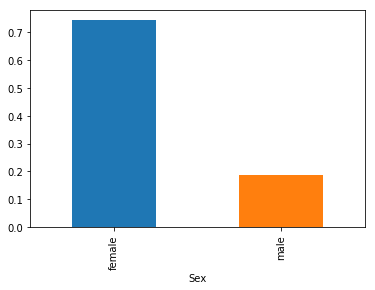

In [25]:
#男女的存活率
data_train.groupby(['Sex'])['Survived'].mean().plot.bar()

#### 由图可知，女性获救的概率远大于男性获救的概率

### 3.2 船舱等级与存活的关系

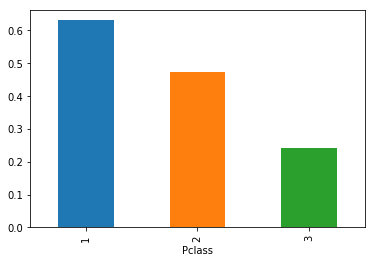

In [29]:
data_train.groupby(['Pclass'])['Survived'].mean().plot.bar()

#### 由图可知，船舱级别越高，存活比例越大

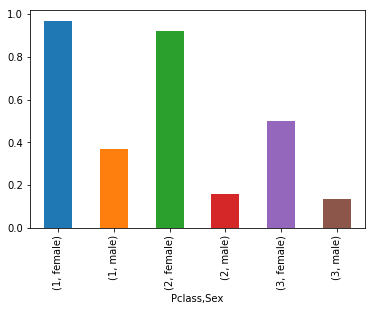

In [44]:
#不同船舱男女的存活比例
data_train.groupby(['Pclass','Sex'])['Survived'].mean().plot.bar()

#### 在不同的船舱中，女性的获救率都是高于男性，同为女性，不同船舱的获救率也不一样

### 3.3 年龄与获救的关系

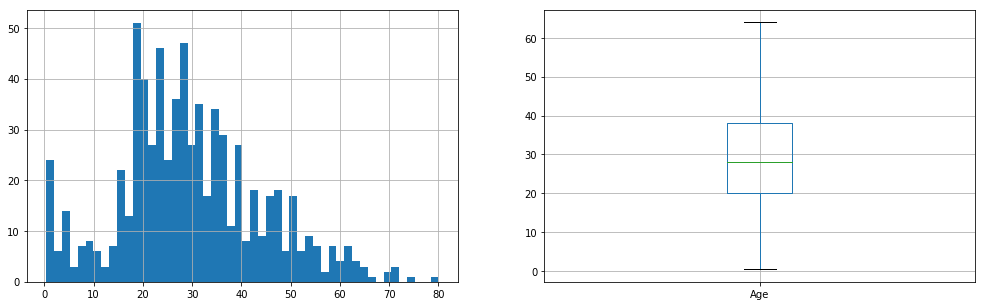

In [9]:
# 年龄分布统计图
plt.figure(figsize = (17,5))
plt.subplot(121)
data_train['Age'].hist(bins = 50)

plt.subplot(122)
data_train.boxplot(column = 'Age',showfliers=False)

plt.show()

#### 由条形统计图可以看出，大部分乘客的年龄都在20--30之间，由箱线图可知，年龄的中位数大约是28岁

In [53]:
data_train['Age'].describe()

count    891.00000
mean      29.63477
std       13.77876
min        0.42000
25%       21.00000
50%       28.00000
75%       37.00000
max       80.00000
Name: Age, dtype: float64

#### 将年龄分组，来统计其生存率

In [57]:
#年龄分组
bins = [0,12,18,65,80]
data_train['Age_group'] = pd.cut(data_train['Age'],bins)

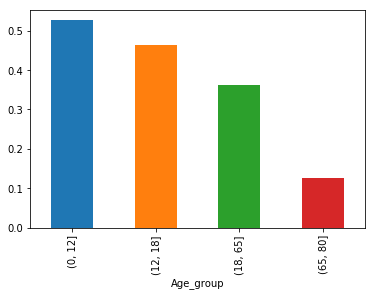

In [61]:
#根据年龄分组来统计生存率
data_train.groupby('Age_group')['Survived'].mean().plot.bar()

### 3.4 有无兄弟姐妹与存活率的关系

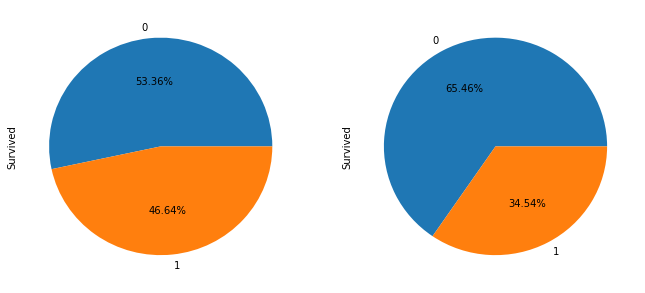

In [100]:
SibSp_df = data_train[data_train['SibSp'] != 0]
not_SibSp_df = data_train[data_train['SibSp'] == 0]

plt.figure(figsize=(11,5))
plt.subplot(121)
SibSp_df.groupby('Survived')['Survived'].count().plot.pie(autopct = '%1.2f%%')
plt.xlabel = 'SibSp'

plt.subplot(122)
not_SibSp_df.groupby('Survived')['Survived'].count().plot.pie(autopct = '%1.2f%%')
plt.xlabel = 'No-SibSp'

plt.show()

#### 由饼图可知，有兄弟姐妹的获救概率更高

### 3.5 有无父母小孩与存活率的关系

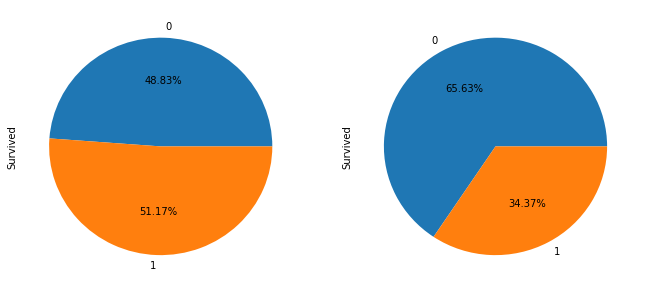

In [102]:
Parch_df = data_train[data_train['Parch'] != 0]
not_Parch_df = data_train[data_train['Parch'] == 0]

plt.figure(figsize=(11,5))
plt.subplot(121)
Parch_df.groupby('Survived')['Survived'].count().plot.pie(autopct = '%1.2f%%')
plt.xlabel = 'Parch'

plt.subplot(122)
not_Parch_df.groupby('Survived')['Survived'].count().plot.pie(autopct = '%1.2f%%')
plt.xlabel = 'No-Parch'

plt.show()

#### 由饼图可知，有父母或小孩的获救率更高

### 3.6 亲友的人数与生存之间的关系

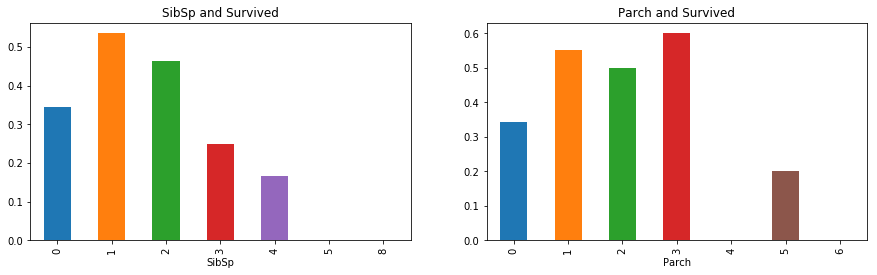

In [10]:
#分别统计兄弟姐妹或父母小孩的人数与获救的关系
fig,ax = plt.subplots(1,2,figsize = (15,4))
data_train.groupby('SibSp')['Survived'].mean().plot.bar(ax = ax[0])
ax[0].set_title('SibSp and Survived')

data_train.groupby('Parch')['Survived'].mean().plot.bar(ax = ax[1])
ax[1].set_title('Parch and Survived')

plt.show()

#### 由图可以看出，兄弟姐妹或父母小孩的个数较少或很多时，获救率都不高，反而亲人在1--2个之间容易获救

### 3.7 将亲人的人数加起来作为一个家庭，分析家庭人数与获救的关系

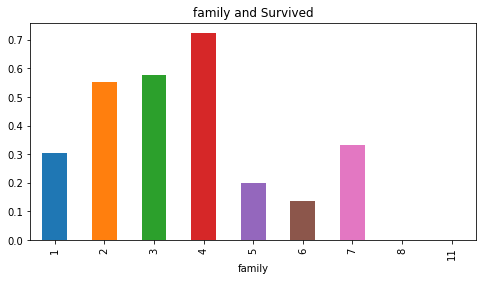

In [11]:
data_train['family'] = data_train['SibSp'] + data_train['Parch'] + 1
data_train.groupby('family')['Survived'].mean().plot.bar(figsize = (8,4),title = 'family and Survived')

#### 跟上述分析类似，家庭成员在2--4之间的最容易获救

## 4.票价与存活的关系

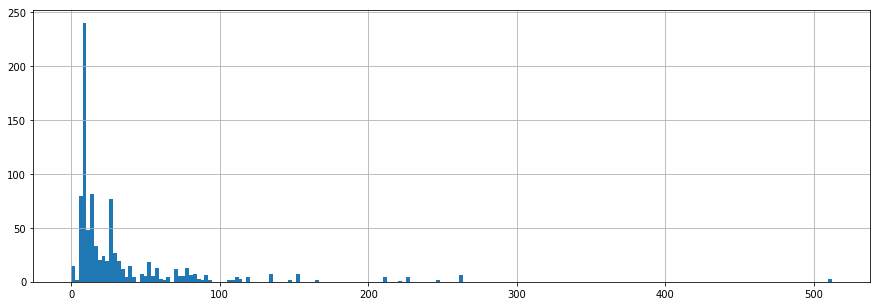

In [149]:
#先分析票价总体情况
data_train['Fare'].hist(bins = 200,figsize = (15,5))

#### 票价总体都在100以内

In [163]:
# 将票价分组
bins = [-1,10,20,30,40,50,60,70,80,90,100,200,300,600]
data_train['Fare_group'] = pd.cut(data_train['Fare'],bins)

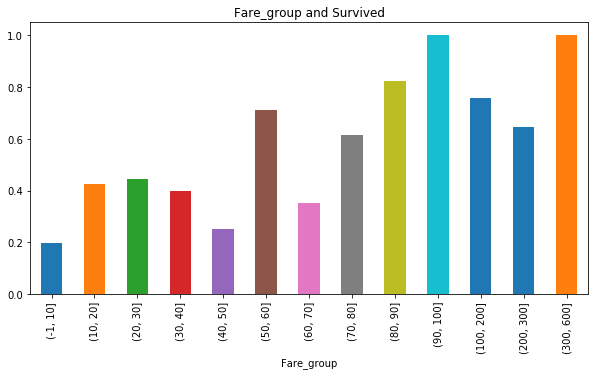

In [165]:
data_train.groupby('Fare_group')['Survived'].mean().plot.bar(figsize = (10,5),title = 'Fare_group and Survived')

#### 由以上票价分组后的获救率来看，票价越高，越容易获救

## 5. 登船港口与存活率的关系

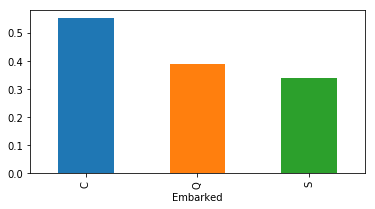

In [170]:
data_train.groupby('Embarked')['Survived'].mean().plot.bar(figsize = (6,3))

#### 由图可知，每个港口的存活率都不一样，在C港口登船的人的存活率最高

## 6.特征工程

### 6.1 将Sex和Embarked两个特性进行one-hot编码

In [12]:
data_train = data_train.join(pd.get_dummies(data_train['Embarked']))
data_train = data_train.join(pd.get_dummies(data_train['Sex']))

### 6.2 打算选用以下特征来训练数据

In [189]:
# 选用这11个特征用逻辑回归算法学习
features = ['Pclass','Age','SibSp','Parch','Fare','family','C','Q','S','female','male','Survived']

## 7. 逻辑回归模型进行训练数据

In [195]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

lr = LogisticRegression(random_state = 1)
lr.fit(data_train[features[:-1]],data_train[features[-1]])
scores = model_selection.cross_val_score(lr,data_train[features[:-1]],data_train[features[-1]],cv = 3)
print (scores)
print (scores.mean())

[0.78451178 0.7979798  0.8013468 ]
0.7946127946127947
